In [1]:
# Cell 1 – Install core dependencies (run once after kernel restart)
!pip install -q spacy==3.6.1 transformers==4.44.2 datasets==2.19.2 accelerate==0.34.2 sentencepiece==0.2.0 evaluate==0.4.2 wordcloud==1.9.3
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 69.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 106.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.3/548.3 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Cell 2 – Configure environment (silence tokenizers warning)
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
# Cell 3 – Helper module (BioBERT+RoBERTa+BERT ensemble, T5 & PEGASUS summaries, fast side-effect heuristics)
from pathlib import Path

core_code = """
import os
import re
from collections import Counter
from typing import Dict, List, Tuple, Iterable

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F

from transformers import (
    AutoTokenizer,
    AutoModel,
    pipeline,
)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import spacy

sns.set_theme(style="whitegrid")

TARGET_EMOTIONS = ["hope", "trust", "fear", "frustration", "joy", "sadness", "anger", "surprise"]

EMOTION_NORMALIZATION = {
    "joy": "joy",
    "happiness": "joy",
    "delight": "joy",
    "excitement": "hope",
    "optimism": "hope",
    "anticipation": "hope",
    "hope": "hope",
    "relief": "hope",
    "curiosity": "hope",
    "love": "trust",
    "caring": "trust",
    "admiration": "trust",
    "approval": "trust",
    "gratitude": "trust",
    "trust": "trust",
    "affection": "trust",
    "pride": "trust",
    "calm": "trust",
    "fear": "fear",
    "nervousness": "fear",
    "anxiety": "fear",
    "worry": "fear",
    "terror": "fear",
    "sadness": "sadness",
    "grief": "sadness",
    "remorse": "sadness",
    "disappointment": "frustration",
    "annoyance": "frustration",
    "frustration": "frustration",
    "disgust": "frustration",
    "boredom": "frustration",
    "anger": "anger",
    "rage": "anger",
    "irritation": "frustration",
    "surprise": "surprise",
    "amazement": "surprise",
    "neutral": "trust",
}

SYMPTOM_TERMS = [
    "nausea", "dizzy", "dizziness", "headache", "fatigue", "insomnia", "anxiety",
    "depression", "vomiting", "diarrhea", "constipation", "dry mouth",
    "weight gain", "weight loss", "sweating", "tremor", "tremors", "rash", "itching",
    "muscle pain", "joint pain", "stomach pain", "cramps", "blurred vision",
    "fainting", "palpitations", "shortness of breath", "cough", "sore throat",
    "weakness", "irritability", "restlessness", "confusion", "memory loss",
    "tingling", "numbness", "chills", "fever", "loss of appetite", "heartburn",
    "gas", "bloating", "back pain", "abdominal pain", "leg pain", "hand tremor",
    "lightheaded", "sleepiness", "agitation", "fear", "panic", "drowsy", "drowsiness",
    "shakiness", "sensitivity", "blurred", "anxious", "upset stomach", "dry eyes",
    "weak", "sluggish", "tired", "irritable", "restless", "sleepless"
]

def basic_clean(df: pd.DataFrame) -> pd.DataFrame:
    df = df.dropna(subset=["review", "drugName"]).copy()
    df["condition"] = df["condition"].fillna("unknown")
    df["rating"] = df["rating"].fillna(df["rating"].median())
    df["usefulCount"] = df["usefulCount"].fillna(0)
    if "review_length" not in df.columns:
        df["review_length"] = df["review"].astype(str).str.split().apply(len)
    df["review"] = df["review"].astype(str).str.replace(r"\\s+", " ", regex=True).str.strip()
    df["condition"] = df["condition"].astype(str).str.lower().str.strip()
    df["drugName"] = df["drugName"].astype(str).str.strip()
    return df

class BioBertPromptScorer:
    def __init__(self, candidate_labels: List[str], device: str = None, max_length: int = 256):
        self.model_name = "dmis-lab/biobert-base-cased-v1.1"
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.max_length = max_length

        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModel.from_pretrained(self.model_name)
        self.model.to(self.device)
        self.model.eval()

        self.candidate_labels = candidate_labels
        self.prompts = {
            label: f"This biomedical drug review expresses a sense of {label}."
            for label in candidate_labels
        }
        self.prompt_embeddings = self._encode_texts(list(self.prompts.values()), batch_size=len(self.prompts))

    def _encode_texts(self, texts: List[str], batch_size: int = 8) -> torch.Tensor:
        embeddings = []
        with torch.no_grad():
            for start in range(0, len(texts), batch_size):
                batch = texts[start:start + batch_size]
                encoded = self.tokenizer(
                    batch,
                    padding=True,
                    truncation=True,
                    max_length=self.max_length,
                    return_tensors="pt",
                )
                encoded = {k: v.to(self.device) for k, v in encoded.items()}
                outputs = self.model(**encoded)
                token_embeddings = outputs.last_hidden_state
                mask_expanded = encoded["attention_mask"].unsqueeze(-1).expand(token_embeddings.size()).float()
                sum_embeddings = torch.sum(token_embeddings * mask_expanded, dim=1)
                sum_mask = torch.clamp(mask_expanded.sum(dim=1), min=1e-9)
                sentence_embeddings = (sum_embeddings / sum_mask).cpu()
                embeddings.append(sentence_embeddings)
        return torch.cat(embeddings, dim=0)

    def score(self, texts: Iterable[str], batch_size: int = 8) -> List[Dict[str, float]]:
        if isinstance(texts, str):
            texts = [texts]
        text_embeddings = self._encode_texts(list(texts), batch_size=batch_size)
        prompt_norm = F.normalize(self.prompt_embeddings, p=2, dim=1)
        scores = []
        for emb in text_embeddings:
            emb_norm = F.normalize(emb.unsqueeze(0), p=2, dim=1)
            cosine_scores = torch.matmul(emb_norm, prompt_norm.T).squeeze(0)
            cosine_scores = cosine_scores - cosine_scores.min()
            total = torch.clamp(cosine_scores.sum(), min=1e-9)
            probs = (cosine_scores / total).numpy()
            scores.append({label: float(probs[idx]) for idx, label in enumerate(self.candidate_labels)})
        return scores

class EmotionEnsemble:
    def __init__(self, target_emotions: List[str] = None, device_index: int = None, max_length: int = 256):
        self.target_emotions = target_emotions or TARGET_EMOTIONS
        self.device_index = device_index if device_index is not None else (0 if torch.cuda.is_available() else -1)
        self.max_length = max_length
        self.cache: Dict[str, Dict[str, float]] = {}
        self.weights = {"roberta": 0.4, "bert": 0.25, "biobert": 0.35}

        self.roberta = pipeline(
            task="text-classification",
            model="SamLowe/roberta-base-go_emotions",
            tokenizer="SamLowe/roberta-base-go_emotions",
            device=self.device_index,
            return_all_scores=True,
            truncation=True,
            max_length=self.max_length,
        )
        self.bert = pipeline(
            task="text-classification",
            model="bhadresh-savani/bert-base-uncased-emotion",
            tokenizer="bhadresh-savani/bert-base-uncased-emotion",
            device=self.device_index,
            return_all_scores=True,
            truncation=True,
            max_length=self.max_length,
        )
        bio_device = "cuda" if self.device_index >= 0 and torch.cuda.is_available() else "cpu"
        self.biobert = BioBertPromptScorer(self.target_emotions, device=bio_device, max_length=self.max_length)

    def _normalize(self, raw_scores: Dict[str, Iterable[Dict[str, float]]]) -> Dict[str, float]:
        normalized = {emotion: 0.0 for emotion in self.target_emotions}
        for source, entries in raw_scores.items():
            weight = self.weights.get(source, 1.0)
            if isinstance(entries, dict):
                iterator = [{"label": label, "score": score} for label, score in entries.items()]
            else:
                iterator = entries
            for entry in iterator:
                label = entry["label"].lower()
                emotion = EMOTION_NORMALIZATION.get(label)
                if emotion in normalized:
                    normalized[emotion] += entry["score"] * weight
        min_val = min(normalized.values())
        if min_val < 0:
            normalized = {k: v - min_val for k, v in normalized.items()}
        total = sum(normalized.values())
        if total > 0:
            normalized = {k: v / total for k, v in normalized.items()}
        return normalized

    def predict_batch(self, texts: Iterable[str], batch_size: int = 8) -> List[Dict[str, float]]:
        if isinstance(texts, str):
            texts = [texts]
        cached_results = {}
        missing_texts = []
        for idx, text in enumerate(texts):
            if text in self.cache:
                cached_results[idx] = self.cache[text]
            else:
                missing_texts.append((idx, text))
        if missing_texts:
            indices, raw_texts = zip(*missing_texts)
            roberta_outputs = self.roberta(list(raw_texts), batch_size=batch_size)
            bert_outputs = self.bert(list(raw_texts), batch_size=batch_size)
            biobert_outputs = self.biobert.score(list(raw_texts), batch_size=batch_size)
            for i, idx in enumerate(indices):
                combined = {
                    "roberta": roberta_outputs[i],
                    "bert": bert_outputs[i],
                    "biobert": [{"label": label, "score": float(score)} for label, score in biobert_outputs[i].items()],
                }
                normalized = self._normalize(combined)
                self.cache[raw_texts[i]] = normalized
                cached_results[idx] = normalized
        return [cached_results[idx] for idx in range(len(texts))]

    def predict(self, text: str) -> Dict[str, float]:
        return self.predict_batch([text])[0]

class SummarizerManager:
    def __init__(self, device_index: int = None):
        device = device_index if device_index is not None else (0 if torch.cuda.is_available() else -1)
        self.summarizers = {
            "pegasus": pipeline(
                task="summarization",
                model="google/pegasus-xsum",
                tokenizer="google/pegasus-xsum",
                device=device,
            ),
            "t5": pipeline(
                task="summarization",
                model="t5-base",
                tokenizer="t5-base",
                device=device,
            ),
        }

    def summarize(self, text: str, min_length: int = 30, max_length: int = 90) -> Dict[str, str]:
        clean_text = text.strip()
        if len(clean_text.split()) < 12:
            return {name: clean_text for name in self.summarizers}
        outputs = {}
        for name, model in self.summarizers.items():
            formatted = f"summarize: {clean_text}" if name == "t5" else clean_text
            summary = model(
                formatted,
                min_length=min_length,
                max_length=max_length,
                truncation=True,
                num_beams=4,
                no_repeat_ngram_size=3,
            )[0]["summary_text"]
            outputs[name] = summary
        return outputs

class SideEffectExtractor:
    def __init__(self):
        self.symptom_terms = sorted(set(SYMPTOM_TERMS), key=len, reverse=True)
        try:
            self.nlp = spacy.load("en_core_web_sm")
        except Exception:
            self.nlp = spacy.blank("en")
        self.patterns = [re.compile(rf"\\b{re.escape(term)}\\b", re.IGNORECASE) for term in self.symptom_terms]

    def extract(self, text: str) -> List[str]:
        if not text or not text.strip():
            return []
        review = text.strip()
        lower = review.lower()
        found = set()
        for pattern, term in zip(self.patterns, self.symptom_terms):
            if pattern.search(lower):
                found.add(term)
        # add noun chunks containing symptom keywords
        try:
            doc = self.nlp(review)
            for chunk in doc.noun_chunks:
                chunk_lower = chunk.text.lower()
                if any(term in chunk_lower for term in self.symptom_terms):
                    found.add(chunk.text.strip())
        except Exception:
            pass
        ordered = sorted(found, key=lambda span: (lower.find(span.lower()), span.lower()))
        return ordered

side_effect_extractor_singleton = SideEffectExtractor()

def plot_emotion_distribution(emotion_scores: Dict[str, float], title: str = "Emotion Distribution", show: bool = True):
    labels = list(emotion_scores.keys())
    values = [emotion_scores[label] for label in labels]
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.barplot(x=labels, y=values, palette="viridis", ax=ax)
    ax.set_ylim(0, 1)
    ax.set_ylabel("Probability")
    ax.set_title(title)
    ax.tick_params(axis="x", rotation=45)
    fig.tight_layout()
    if show:
        plt.show()
    return fig, ax

def build_side_effect_wordcloud(reviews: List[str], extractor: SideEffectExtractor = None, max_reviews: int = 400, show: bool = True):
    extractor = extractor or side_effect_extractor_singleton
    sampled = reviews[:max_reviews]
    all_effects = []
    for review in sampled:
        all_effects.extend(extractor.extract(review))
    if not all_effects:
        return None
    joined = " ".join(all_effects)
    wc = WordCloud(width=800, height=400, background_color="white").generate(joined)
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    ax.set_title("Side Effect Mentions – Word Cloud")
    fig.tight_layout()
    if show:
        plt.show()
    return fig

class EmotionAwareReviewAnalyzer:
    def __init__(self, emotion_model: EmotionEnsemble, summarizer: SummarizerManager, side_effect_extractor: SideEffectExtractor):
        self.emotion_model = emotion_model
        self.summarizer = summarizer
        self.side_effect_extractor = side_effect_extractor

    def analyze(self, text: str, summary_min_length: int = 30, summary_max_length: int = 90):
        emotion_scores = self.emotion_model.predict(text)
        ranked_emotions = sorted(emotion_scores.items(), key=lambda kv: kv[1], reverse=True)
        side_effects = self.side_effect_extractor.extract(text)
        summaries = self.summarizer.summarize(text, min_length=summary_min_length, max_length=summary_max_length)
        return {
            "emotion_scores": emotion_scores,
            "ranked_emotions": ranked_emotions,
            "side_effects": side_effects,
            "summaries": summaries,
        }

class EmotionAwareRecommender:
    def __init__(
        self,
        emotion_model: EmotionEnsemble,
        content_weight: float = 0.6,
        emotion_weight: float = 0.4,
        max_reviews_per_drug: int = 120,
        batch_size: int = 10,
    ):
        self.emotion_model = emotion_model
        self.content_weight = content_weight
        self.emotion_weight = emotion_weight
        self.max_reviews_per_drug = max_reviews_per_drug
        self.batch_size = batch_size

        self.vectorizer = TfidfVectorizer(
            max_features=5000,
            ngram_range=(1, 2),
            min_df=3,
        )
        self.drug_index: Dict[str, int] = {}
        self.drug_content_matrix: np.ndarray = None
        self.drug_emotion_matrix: np.ndarray = None
        self.metadata: Dict[str, Dict[str, object]] = {}
        self.fitted = False

    def fit(self, df: pd.DataFrame, text_col: str = "review", drug_col: str = "drugName", condition_col: str = "condition"):
        texts = df[text_col].tolist()
        review_matrix = self.vectorizer.fit_transform(texts)

        drugs = sorted(df[drug_col].unique())
        self.drug_index = {drug: idx for idx, drug in enumerate(drugs)}

        content_vectors = []
        emotion_vectors = []
        metadata = {}

        for drug in tqdm(drugs, desc="Building drug profiles"):
            mask = df[drug_col] == drug
            indices = np.where(mask)[0]
            subset_reviews = df.loc[mask, text_col].tolist()
            subset_conditions = df.loc[mask, condition_col].tolist()
            subset_ratings = df.loc[mask, "rating"].tolist()

            sub_matrix = review_matrix[indices]
            centroid = np.asarray(sub_matrix.mean(axis=0)).ravel()
            content_vectors.append(centroid)

            sample_reviews = subset_reviews[: self.max_reviews_per_drug]
            emotion_scores = self.emotion_model.predict_batch(sample_reviews, batch_size=self.batch_size)
            emotion_array = np.array([
                [scores.get(emotion, 0.0) for emotion in self.emotion_model.target_emotions]
                for scores in emotion_scores
            ])
            mean_emotion = emotion_array.mean(axis=0) if len(emotion_array) else np.zeros(len(self.emotion_model.target_emotions))
            emotion_vectors.append(mean_emotion)

            top_conditions = pd.Series(subset_conditions).value_counts().head(3).index.tolist()
            metadata[drug] = {
                "review_count": int(len(subset_reviews)),
                "average_rating": float(np.mean(subset_ratings)) if subset_ratings else np.nan,
                "top_conditions": top_conditions,
                "top_emotions": sorted(
                    zip(self.emotion_model.target_emotions, mean_emotion),
                    key=lambda kv: kv[1],
                    reverse=True,
                )[:3],
            }

        self.drug_content_matrix = np.vstack(content_vectors)
        self.drug_emotion_matrix = np.vstack(emotion_vectors)
        self.metadata = metadata
        self.fitted = True
        return self

    def recommend(self, review_text: str, top_k: int = 5) -> List[Dict[str, object]]:
        if not self.fitted:
            raise RuntimeError("Call fit() before recommend().")

        review_vec = self.vectorizer.transform([review_text]).toarray()
        content_sim = cosine_similarity(review_vec, self.drug_content_matrix)[0]

        emotion_scores = self.emotion_model.predict(review_text)
        emotion_vec = np.array([
            emotion_scores.get(emotion, 0.0)
            for emotion in self.emotion_model.target_emotions
        ]).reshape(1, -1)
        emotion_sim = cosine_similarity(emotion_vec, self.drug_emotion_matrix)[0]

        combined = self.content_weight * content_sim + self.emotion_weight * emotion_sim
        ranked_indices = np.argsort(combined)[::-1][:top_k]
        inverse_index = {idx: drug for drug, idx in self.drug_index.items()}

        recommendations = []
        for idx in ranked_indices:
            drug = inverse_index[idx]
            recommendations.append({
                "drugName": drug,
                "score": float(combined[idx]),
                **self.metadata[drug],
            })
        return recommendations

def compute_dataset_emotion_summary(
    df: pd.DataFrame,
    emotion_model: EmotionEnsemble,
    sample_size: int = 900,
    random_state: int = 42,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    sampled = df.sample(n=min(sample_size, len(df)), random_state=random_state) if len(df) > sample_size else df.copy()
    texts = sampled["review"].tolist()
    emotion_outputs = emotion_model.predict_batch(texts, batch_size=12)
    matrix = np.array([
        [scores.get(emotion, 0.0) for emotion in emotion_model.target_emotions]
        for scores in emotion_outputs
    ])
    mean_scores = matrix.mean(axis=0)
    summary_df = pd.DataFrame({"emotion": emotion_model.target_emotions, "mean_probability": mean_scores})
    augmented = sampled.reset_index(drop=True).copy()
    for col_idx, emotion in enumerate(emotion_model.target_emotions):
        augmented[f"emotion_{emotion}"] = matrix[:, col_idx]
    return summary_df, augmented

__all__ = [
    "TARGET_EMOTIONS",
    "basic_clean",
    "EmotionEnsemble",
    "EmotionAwareReviewAnalyzer",
    "EmotionAwareRecommender",
    "SummarizerManager",
    "SideEffectExtractor",
    "side_effect_extractor_singleton",
    "plot_emotion_distribution",
    "build_side_effect_wordcloud",
    "compute_dataset_emotion_summary",
]
"""

core_path = Path("/kaggle/working/emotion_core_full_fast.py")
core_path.write_text(core_code.strip() + "\n")
print(f"Wrote helper module to {core_path}")

Wrote helper module to /kaggle/working/emotion_core_full_fast.py


In [4]:
# Cell 4 – Imports, config, dataset preview
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from pathlib import Path
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from emotion_core_full_fast import (
    basic_clean,
    EmotionEnsemble,
    EmotionAwareReviewAnalyzer,
    EmotionAwareRecommender,
    SummarizerManager,
    SideEffectExtractor,
    side_effect_extractor_singleton,
    plot_emotion_distribution,
    build_side_effect_wordcloud,
    compute_dataset_emotion_summary,
)

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

DATA_PATH = Path("/kaggle/input/drugdataset/drug_review_test.csv")
assert DATA_PATH.exists(), f"Dataset not found at {DATA_PATH}"
data = pd.read_csv(DATA_PATH)
pd.set_option("display.max_columns", None)
display(data.head(10))
print(f"Dataset shape: {data.shape}")

2025-11-06 04:14:46.441227: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762402486.464090      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762402486.470997      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


,Unnamed: 0,patient_id,drugName,condition,review,rating,date,usefulCount,review_length
0,0,163740,Mirtazapine,depression,"""i've tried a few antidepressants over the yea...",10.0,"February 28, 2012",22,68
1,1,206473,Mesalamine,"crohn's disease, maintenance","""my son has crohn's disease and has done very ...",8.0,"May 17, 2009",17,48
2,2,39293,Contrave,weight loss,"""contrave combines drugs that were used for al...",9.0,"March 5, 2017",35,143
3,3,97768,Cyclafem 1 / 35,birth control,"""i have been on this birth control for one cyc...",9.0,"October 22, 2015",4,149
4,4,208087,Zyclara,keratosis,"""4 days in on first 2 weeks. using on arms an...",4.0,"July 3, 2014",13,60
5,5,215892,Copper,birth control,"""i've had the copper coil for about 3 months n...",6.0,"June 6, 2016",1,109
6,6,169852,Amitriptyline,migraine prevention,"""this has been great for me. i've been on it f...",9.0,"April 21, 2009",32,64
7,7,23295,Methadone,opiate withdrawal,"""ive been on methadone for over ten years and ...",7.0,"October 18, 2016",21,78
8,8,71428,Levora,birth control,"""i was on this pill for almost two years. it d...",2.0,"April 16, 2011",3,93
9,9,196802,Paroxetine,hot flashes,"""holy hell is exactly how i feel. i had been t...",1.0,"February 22, 2017",17,131


Dataset shape: (46108, 9)


In [5]:
# Cell 5 – Cleaning, sampling, class filtering
cleaned = basic_clean(data)

MAX_REVIEWS = 1500  # adjust for speed/coverage
if len(cleaned) > MAX_REVIEWS:
    cleaned = cleaned.sample(n=MAX_REVIEWS, random_state=RANDOM_STATE).reset_index(drop=True)
    print(f"Sampled to {len(cleaned)} reviews for faster runtime.")

min_reviews = 120
drug_counts = cleaned["drugName"].value_counts()
selected_drugs = drug_counts[drug_counts >= min_reviews].index.tolist()
if len(selected_drugs) < 2:
    selected_drugs = drug_counts.head(10).index.tolist()

filtered = cleaned[cleaned["drugName"].isin(selected_drugs)].copy().reset_index(drop=True)
print(f"Using {len(filtered)} reviews across {len(selected_drugs)} drug classes.")

Sampled to 1500 reviews for faster runtime.
Using 216 reviews across 10 drug classes.


In [6]:
# Cell 6 – Baseline classical models (LogReg & Linear SVM)
feature_cols = ["review", "condition", "rating", "usefulCount", "review_length"]
target_col = "drugName"

X = filtered[feature_cols]
y = filtered[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=RANDOM_STATE,
)

text_feature = "review"
categorical_features = ["condition"]
numeric_features = ["rating", "usefulCount", "review_length"]

preprocessor = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(max_features=4000, ngram_range=(1, 2), min_df=3), text_feature),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", StandardScaler(), numeric_features),
    ],
    remainder="drop",
    sparse_threshold=0.3,
)

models = {
    "Logistic Regression (saga)": LogisticRegression(
        max_iter=800,
        solver="saga",
        multi_class="multinomial",
        n_jobs=-1,
        random_state=RANDOM_STATE,
    ),
    "Linear SVM": LinearSVC(
        C=1.0,
        max_iter=2500,
        random_state=RANDOM_STATE,
    ),
}

results = {}
for name, clf in models.items():
    pipeline = Pipeline([
        ("prep", preprocessor),
        ("clf", clf),
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = {
        "pipeline": pipeline,
        "accuracy": acc,
        "classification_report": classification_report(y_test, y_pred, zero_division=0),
        "confusion_matrix": confusion_matrix(y_test, y_pred, labels=sorted(y.unique())),
    }
    print(f"{name} accuracy: {acc:.3f}")

best_model_name, best_payload = max(results.items(), key=lambda kv: kv[1]["accuracy"])
print(f"\nBest model: {best_model_name}\n")
print(best_payload["classification_report"])

Logistic Regression (saga) accuracy: 0.444
Linear SVM accuracy: 0.593

Best model: Linear SVM

                                    precision    recall  f1-score   support

                        Duloxetine       1.00      0.67      0.80         3
                      Escitalopram       1.00      0.67      0.80         3
Ethinyl estradiol / levonorgestrel       0.00      0.00      0.00         4
 Ethinyl estradiol / norethindrone       0.33      0.40      0.36         5
  Ethinyl estradiol / norgestimate       0.60      0.43      0.50         7
                      Etonogestrel       0.80      0.57      0.67         7
                    Levonorgestrel       0.56      1.00      0.72         9
                            Mirena       0.50      0.25      0.33         4
                         Nexplanon       0.62      0.62      0.62         8
                       Phentermine       0.80      1.00      0.89         4

                          accuracy                           0.59  

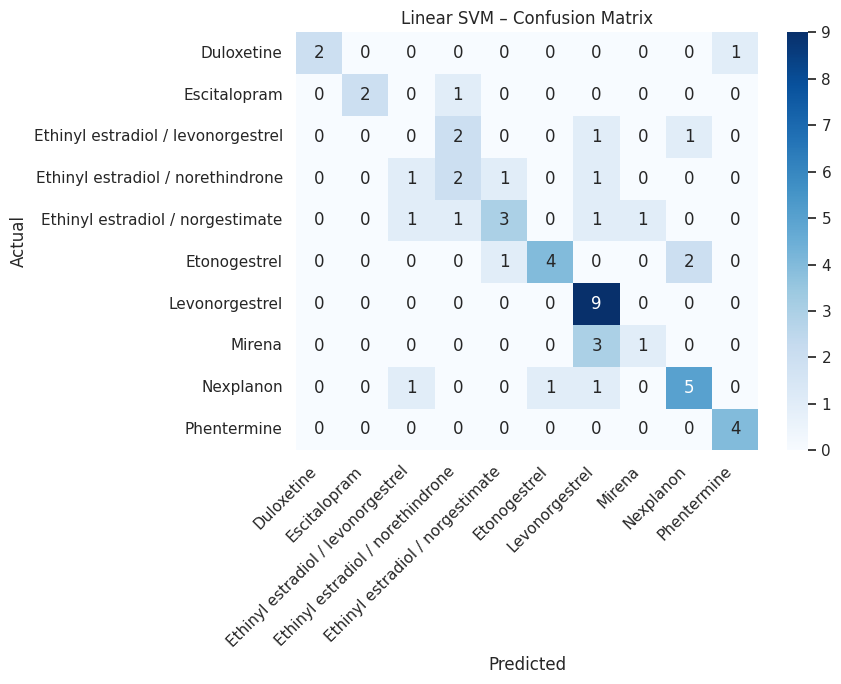

In [7]:
# Cell 7 – Confusion matrix for best baseline
cm = best_payload["confusion_matrix"]
labels = sorted(y.unique())
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(9, 7))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title(f"{best_model_name} – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [8]:
# Cell 8 – LLM-based analyzers (Emotion ensemble + T5 & PEGASUS + heuristic side effects)
emotion_model = EmotionEnsemble()
summarizer_manager = SummarizerManager()
side_effect_extractor = side_effect_extractor_singleton  # shared instance

review_analyzer = EmotionAwareReviewAnalyzer(
    emotion_model=emotion_model,
    summarizer=summarizer_manager,
    side_effect_extractor=side_effect_extractor,
)

sample_review = filtered["review"].iloc[0]
sample_analysis = review_analyzer.analyze(sample_review)

print("Sample review:")
print(sample_review)

print("\nEmotion scores:")
for emotion, score in sample_analysis["ranked_emotions"]:
    print(f"  {emotion}: {score:.3f}")

print("\nSide effects:", sample_analysis["side_effects"])
print("\nSummaries:")
for name, summary in sample_analysis["summaries"].items():
    print(f"  {name.upper()}: {summary}")

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/935 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/259 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Sample review:
"i've been taking seasonique for two years. when i first started using it nothing major really changed with my body, but after the first couple of months i started to break out more often and my sex drive was practically non-existent. two years later, the acne problem isn't as bad, but my sex drive is still gone and during intercourse i am also dry which makes intercourse uncomfortable. this was my first birth-control and i am now switching."

Emotion scores:
  fear: 0.261
  trust: 0.227
  sadness: 0.142
  frustration: 0.131
  anger: 0.075
  surprise: 0.058
  joy: 0.058
  hope: 0.048

Side effects: []

Summaries:
  PEGASUS: What is the most common side-effect of taking seasonique, a birth-control pill, for acne and low sex drive, and why is it so hard to switch?
  T5: after taking seasonique for two years i started to break out more often . during intercourse i am also dry which makes intercourse uncomfortable . two years later, the acne problem isn't as bad as before .


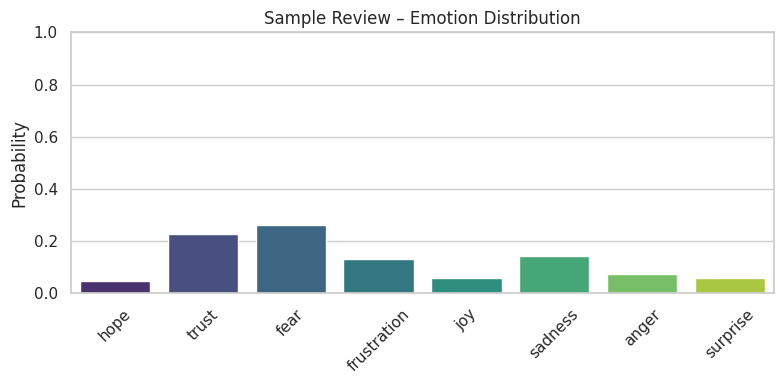

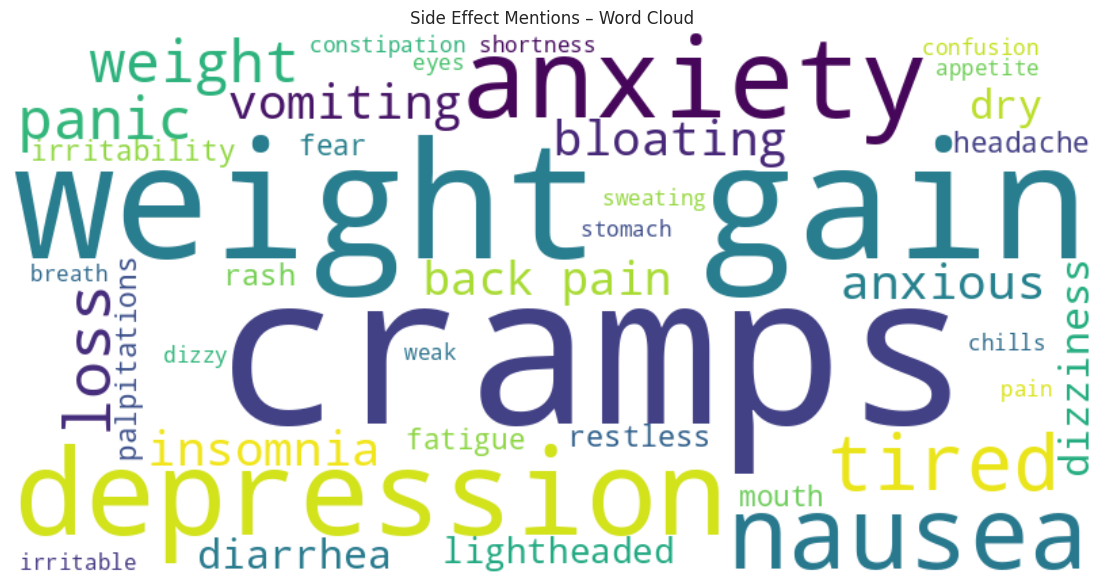

In [9]:
# Cell 9 – Visualisations (emotion bar + side-effect word cloud)
plot_emotion_distribution(sample_analysis["emotion_scores"], title="Sample Review – Emotion Distribution")
_ = build_side_effect_wordcloud(
    filtered["review"].tolist(),
    extractor=side_effect_extractor,
    max_reviews=350,
)

Building drug profiles:   0%|          | 0/10 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Your max_length is set to 90, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 90, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


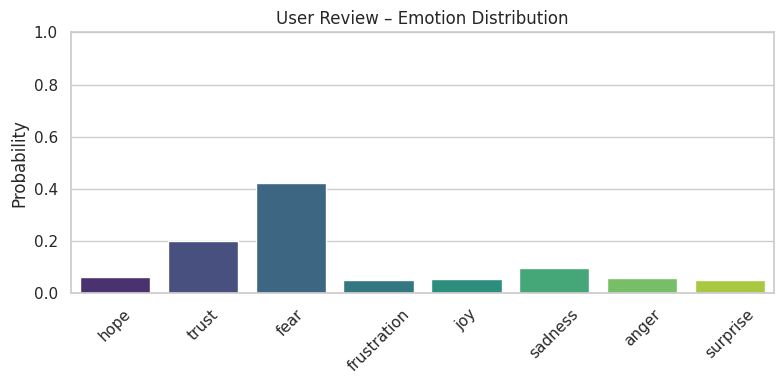

Detected side effects: ['anxiety', 'dizzy']

Summaries:
PEGASUS: I've been taking this medicine for two weeks, and it helps with my anxiety, but I feel dizzy and worried about the side effects.
T5: nicolaus mills: i've been taking this medicine for two weeks . mills says it helps with my anxiety, but i feel dizzy and worried about the side effects .

Top recommendations:
1. Escitalopram | score=0.475 | avg_rating=6.62 | reviews=13 | top_conditions=['depression', 'generalized anxiety disorde', 'anxiety'] | top_emotions=fear:0.23, joy:0.21, sadness:0.15
2. Ethinyl estradiol / levonorgestrel | score=0.428 | avg_rating=5.61 | reviews=18 | top_conditions=['birth control', 'abnormal uterine bleeding'] | top_emotions=sadness:0.21, joy:0.16, trust:0.16
3. Duloxetine | score=0.409 | avg_rating=6.17 | reviews=12 | top_conditions=['anxiety', 'depression', 'ibromyalgia'] | top_emotions=sadness:0.19, trust:0.18, joy:0.18
4. Levonorgestrel | score=0.405 | avg_rating=7.19 | reviews=37 | top_condition

In [10]:
# Cell 10 – Hybrid recommender demo with a custom review
recommender = EmotionAwareRecommender(
    emotion_model=emotion_model,
    content_weight=0.6,
    emotion_weight=0.4,
    max_reviews_per_drug=120,
    batch_size=10,
)

recommender.fit(filtered)

user_review = ("I've been taking this medicine for two weeks. "
               "It helps with my anxiety, but I feel dizzy and worried about the side effects.")

user_analysis = review_analyzer.analyze(user_review)

plot_emotion_distribution(user_analysis["emotion_scores"], title="User Review – Emotion Distribution")
print("Detected side effects:", user_analysis["side_effects"])
print("\nSummaries:")
for name, summary in user_analysis["summaries"].items():
    print(f"{name.upper()}: {summary}")

recommendations = recommender.recommend(user_review, top_k=5)
print("\nTop recommendations:")
for idx, rec in enumerate(recommendations, start=1):
    top_emotions = ", ".join(f"{emo}:{score:.2f}" for emo, score in rec["top_emotions"])
    print(
        f"{idx}. {rec['drugName']} | score={rec['score']:.3f} | avg_rating={rec['average_rating']:.2f} "
        f"| reviews={rec['review_count']} | top_conditions={rec['top_conditions']} | top_emotions={top_emotions}"
    )

In [11]:
# Cell 10: Dataset-level emotion snapshot (sampled) with augmentation
emotion_summary_df, emotion_augmented_sample = compute_dataset_emotion_summary(
    filtered,
    emotion_model,
    sample_size=1500,
)
display(emotion_summary_df)

,emotion,mean_probability
0,hope,0.098858
1,trust,0.182112
2,fear,0.116855
3,frustration,0.086102
4,joy,0.184958
5,sadness,0.185716
6,anger,0.084750
7,surprise,0.060649


In [12]:
# Cell 11 – Dataset-level emotion snapshot + export augmented sample
emotion_summary_df, emotion_augmented_sample = compute_dataset_emotion_summary(
    filtered,
    emotion_model,
    sample_size=900,
)
display(emotion_summary_df)

output_path = Path("/kaggle/working/emotion_augmented_sample.csv")
emotion_augmented_sample.to_csv(output_path, index=False)
print(f"Saved sample with emotion probabilities to {output_path}")

,emotion,mean_probability
0,hope,0.098858
1,trust,0.182112
2,fear,0.116855
3,frustration,0.086102
4,joy,0.184958
5,sadness,0.185716
6,anger,0.084750
7,surprise,0.060649


Saved sample with emotion probabilities to /kaggle/working/emotion_augmented_sample.csv


=== Emotion-Aware Review Analyzer ===
Enter a drug review (or 'exit' to quit):



Your review:  I’ve been taking this medicine for three weeks. It reduced my pain but gives me headaches and I’m worried about the nausea.


Your max_length is set to 90, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)



--- Analyzing review ---


Your max_length is set to 90, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


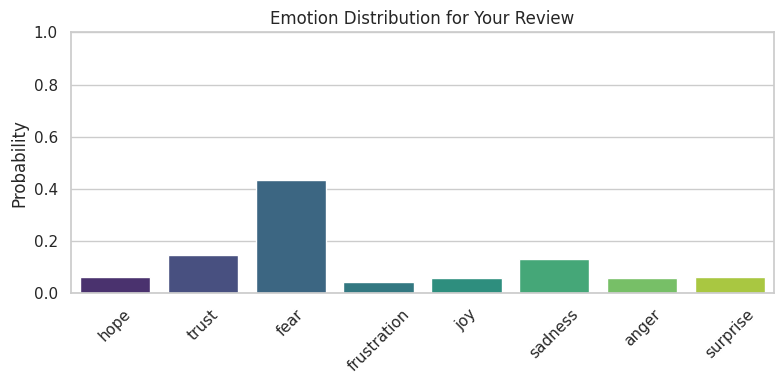


Detected Side Effects:
nausea

Summaries:
PEGASUS: I’ve been taking this medicine for a few weeks and it reduced my pain but gives me headaches and I’m worried about the nausea.
T5: i've been taking this medicine for three weeks . it reduced my pain but gives me headaches and I'm worried about the nausea .

--- Generating recommendations ---

Top Drug Recommendations:
1. Escitalopram | score=0.437 | avg_rating=6.62 | reviews=13 | top_conditions=['depression', 'generalized anxiety disorde', 'anxiety'] | top_emotions=fear:0.23, joy:0.21, sadness:0.15
2. Ethinyl estradiol / levonorgestrel | score=0.425 | avg_rating=5.61 | reviews=18 | top_conditions=['birth control', 'abnormal uterine bleeding'] | top_emotions=sadness:0.21, joy:0.16, trust:0.16
3. Levonorgestrel | score=0.395 | avg_rating=7.19 | reviews=37 | top_conditions=['birth control', 'emergency contraception', 'abnormal uterine bleeding'] | top_emotions=joy:0.19, sadness:0.18, trust:0.17
4. Duloxetine | score=0.395 | avg_rating=6.

In [ ]:
# Cell 12: Interactive Input – User Review Analyzer & Drug Recommendation

from IPython.display import display, HTML

def interactive_review_analysis():
    print("=== Emotion-Aware Review Analyzer ===")
    print("Enter a drug review (or 'exit' to quit):\n")

    while True:
        user_review = input("Your review: ").strip()
        if user_review.lower() in {"exit", "quit"}:
            print("Session ended.")
            break
        if not user_review:
            print("Please enter a valid review text.\n")
            continue

        print("\n--- Analyzing review ---")
        user_analysis = review_analyzer.analyze(user_review)

        # Emotion Plot
        plot_emotion_distribution(
            user_analysis["emotion_scores"], 
            title="Emotion Distribution for Your Review", 
            show=True
        )

        # Display side effects & summaries
        print("\nDetected Side Effects:")
        if user_analysis["side_effects"]:
            print(", ".join(user_analysis["side_effects"]))
        else:
            print("No explicit side effects detected.")

        print("\nSummaries:")
        for name, summary in user_analysis["summaries"].items():
            print(f"{name.upper()}: {summary}")

        # Recommendations
        print("\n--- Generating recommendations ---")
        recommendations = recommender.recommend(user_review, top_k=5)

        print("\nTop Drug Recommendations:")
        for idx, rec in enumerate(recommendations, start=1):
            top_emotions = ", ".join(f"{emo}:{score:.2f}" for emo, score in rec["top_emotions"])
            print(
                f"{idx}. {rec['drugName']} | score={rec['score']:.3f} | avg_rating={rec['average_rating']:.2f} "
                f"| reviews={rec['review_count']} | top_conditions={rec['top_conditions']} | top_emotions={top_emotions}"
            )
        print("\n" + "="*80 + "\n")

# Run the interactive loop
interactive_review_analysis()
